<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [1]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_5.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 100

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [2]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=af2360c4694dd457ce2b58b297bcd0de9fedaba621e30ca18fa01b29d9bc0d55
  Stored in directory: /root/.cache/pip/wheels/ab/fa/1b/75d9a713279796785711bd0bad8334aaace560c0bd28830c8c
  Created wheel for stringdist: filename=StringDist-1.0.9-cp39-cp39-linux_x86_64.whl size=24712 sha256=ea8c48ccfb3c173b9f1b992547286a1e140e776c9d93f1eede1b8411cffc7de9
  Stored in directory: /root/.cache/pip/wheels/77/24/44/b12b9612fd07e141e6b4f1bb2001c621515bd0cac1014a783a
Successfully built intervaltree stringdist
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 9.6 MB/s eta 0:00:00


In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [5]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [6]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,105764,Transfer,2134-03-01 00:38:40
1,112013,Transfer,2187-02-12 00:42:40
2,150193,Transfer,2192-06-01 01:13:39
3,144980,Transfer,2169-08-14 00:30:19
4,122192,Transfer,2120-04-15 00:32:00
...,...,...,...
230665,109352,Admitted,2167-04-01 16:57:00
230666,166032,Admitted,2198-09-08 20:03:00
230667,120514,Admitted,2163-09-07 13:31:00
230668,175280,Admitted,2204-01-20 16:12:00


## Section 2: Process Discovery

In [7]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-7-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

Number of cases: 42652
Number of events: 230668
Start events: {'Admitted': 36389, 'Transfer': 6208, 'Discharged': 55}
End events: {'Discharged': 34688, 'Left ICU': 7947, 'Transfer': 14, 'Admitted': 3}


In [8]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [9]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 28937
Number of events: 157999
Start events: {'Admitted': 28937}
End events: {'Discharged': 28937}


In [10]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

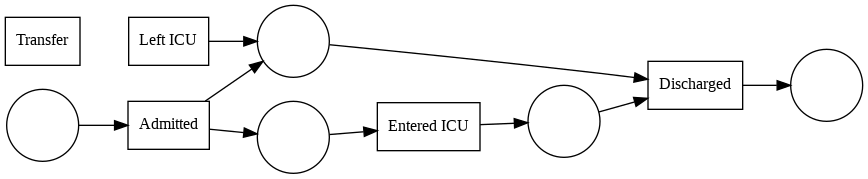

In [12]:
import graphviz
pm.view_petri_net(petri_net=net)

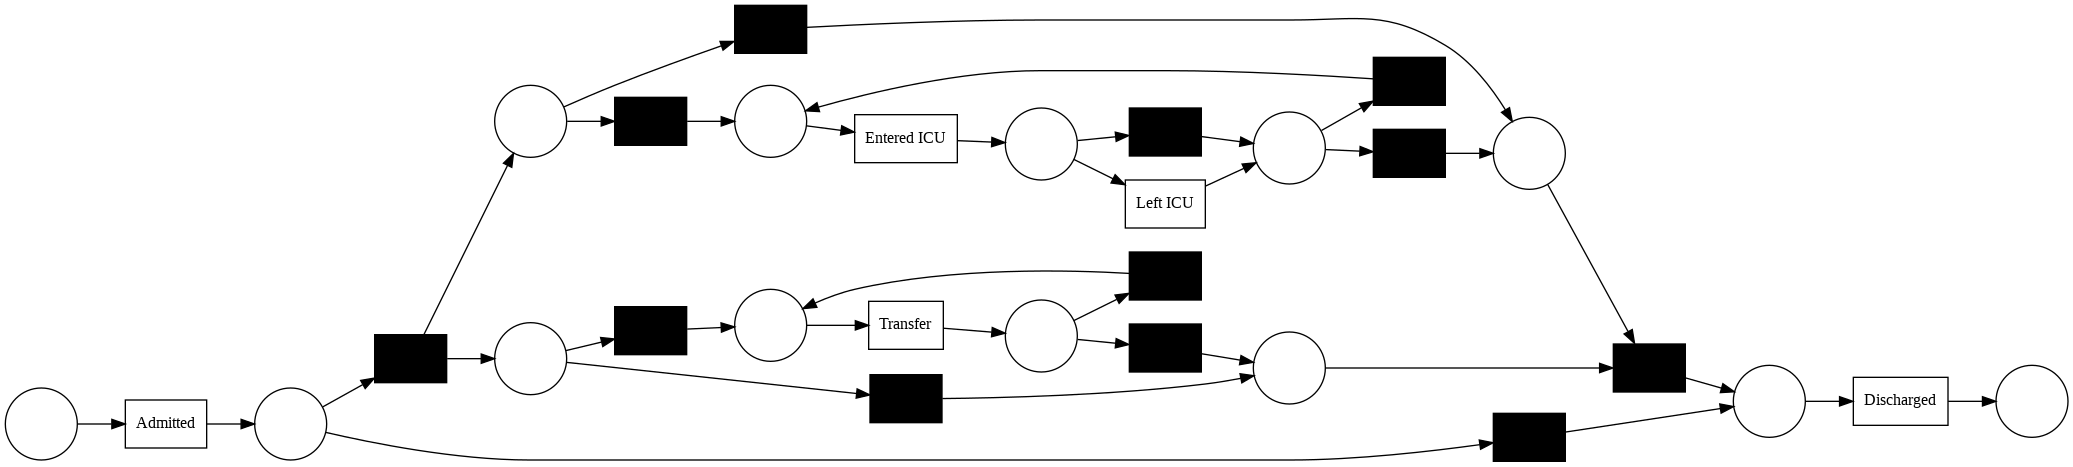

In [13]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

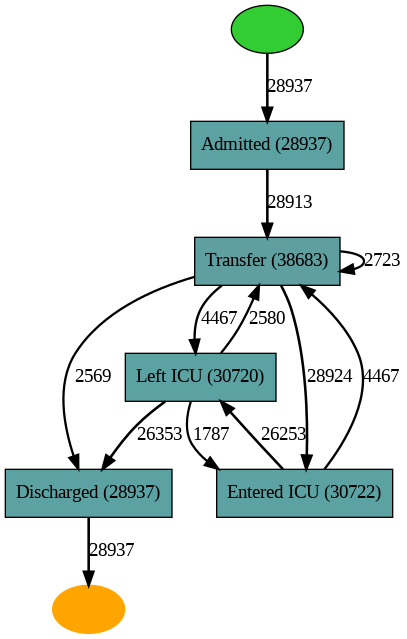

In [14]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

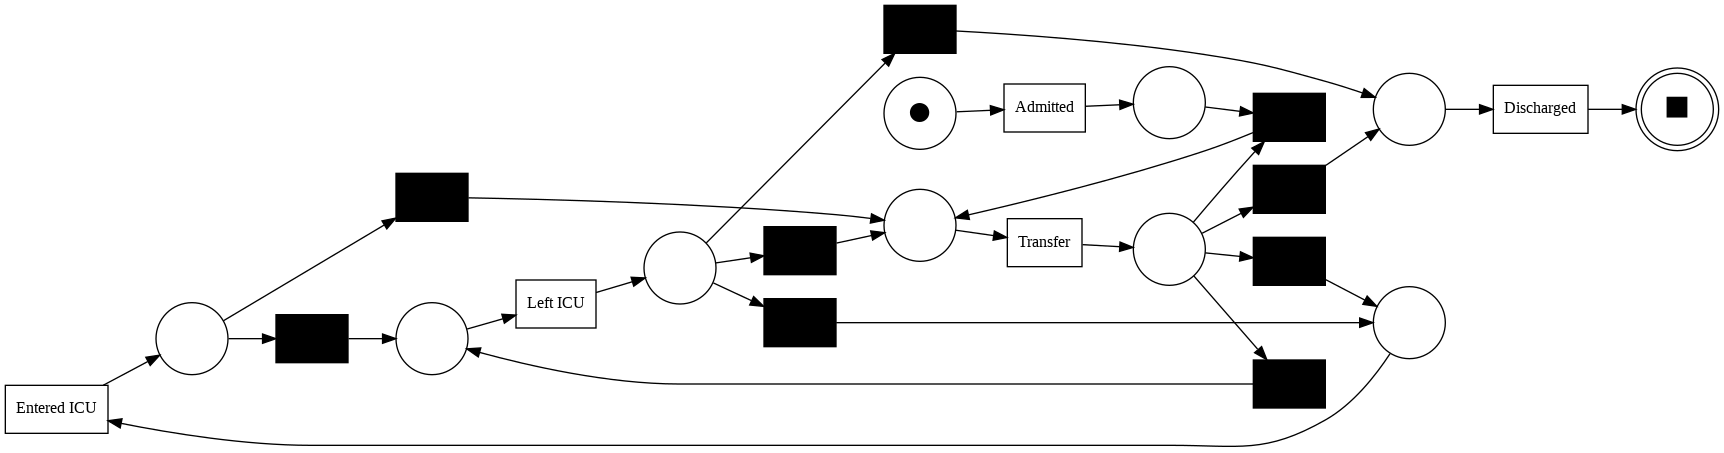

In [15]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

##Section 3: Preprocessing Data

In [16]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  # random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = el[el['trace'].isin(random_traces)]
  return partial_el


In [17]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,trace,activity,timestamp
2014,364,Admitted,2163-04-15 08:36:00
2015,364,Transfer,2163-04-15 08:38:06
2016,364,Entered ICU,2163-04-15 08:38:06
2017,364,Left ICU,2163-04-16 00:08:04
2018,364,Discharged,2163-04-19 14:05:00
...,...,...,...
153071,28035,Entered ICU,2191-07-29 10:08:46
153072,28035,Transfer,2191-07-29 10:09:07
153073,28035,Transfer,2191-07-29 12:11:57
153074,28035,Left ICU,2191-07-30 19:08:52


In [18]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity

({'Admitted': '1',
  'Transfer': '2',
  'Entered ICU': '3',
  'Left ICU': '4',
  'Discharged': '5'},
 {'1': 'Admitted',
  '2': 'Transfer',
  '3': 'Entered ICU',
  '4': 'Left ICU',
  '5': 'Discharged'})

In [42]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,trace,activity,timestamp
6856,1242,Admitted,2106-06-22 04:15:00
6857,1242,Transfer,2106-06-22 04:16:19
6858,1242,Entered ICU,2106-06-22 04:16:19
6859,1242,Left ICU,2106-06-23 21:07:01
6860,1242,Discharged,2106-06-25 17:56:00
...,...,...,...
147183,26954,Admitted,2167-12-13 14:45:00
147184,26954,Transfer,2167-12-13 14:46:52
147185,26954,Entered ICU,2167-12-13 14:46:52
147186,26954,Left ICU,2167-12-16 00:17:52


In [47]:
# find the first timestamp in dataset
start_time = partial_el['timestamp'].min()

In [62]:
import numpy as np

# transform train data into prefix, suffix and label
def label_train(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  
  for t in unique_traces:
    df = el[:][el.trace == t].sort_values(by='timestamp')
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = (df['timestamp'][i] - start_time).total_seconds() / 10_000_000_000
      timestamps.append(timestamp)
    
    length = len(activities)
    
    for i in range(length):
      label = activities[i]
      time_label = timestamps[i]
      prefix = activities[:i]
      prefix_times = timestamps[:i]

      suffix = []
      suffix_times = []

      if i != length - 1:
        suffix = activities[i+1:]
        suffix_times = timestamps[i+1:]

      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      padding = []
      
      while len(prefix_times) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix_times =  padding + prefix_times

      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      while len(suffix_times) < PREFIX_LENGTH:
        suffix_times.append('0')
      
      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      prefix_times_arr.append(np.array(prefix_times[0:PREFIX_LENGTH], dtype=int))
      suffix_times_arr.append(np.array(suffix_times[0:PREFIX_LENGTH], dtype=int))
      label_arr.append(label)
      label_times_arr.append(time_label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix times' : prefix_times_arr,
                       'suffix times' : suffix_times_arr,
                       'activity label' : label_arr,
                       'time label': label_times_arr})
  

labeled_train_el = label_train(train_el)
labeled_train_el

,prefix,suffix,prefix times,suffix times,activity label,time label
0,"[0, 0, 0, 0, 0]","[2, 3, 4, 5, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",1,0.193916
1,"[0, 0, 0, 0, 1]","[3, 4, 5, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",2,0.193916
2,"[0, 0, 0, 1, 2]","[4, 5, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",3,0.193916
3,"[0, 0, 1, 2, 3]","[5, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",4,0.193922
4,"[0, 1, 2, 3, 4]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",5,0.193953
...,...,...,...,...,...,...
436,"[0, 0, 0, 1, 2]","[2, 2, 4, 5, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",3,0.283185
437,"[0, 0, 1, 2, 3]","[2, 4, 5, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",2,0.283185
438,"[0, 1, 2, 3, 2]","[4, 5, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",2,0.283186
439,"[1, 2, 3, 2, 2]","[5, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",4,0.283197


In [49]:
labeled_train_el, validation_el = train_test_split(labeled_train_el, test_size=VALIDATION_SIZE, random_state=9)

In [50]:
def format_input(el):
  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  prefix_t = np.array(el['prefix times'])
  prefix_t = np.stack(prefix_t)
  prefix_t = prefix_t.reshape(prefix_t.shape[0], prefix_t.shape[1], 1)

  suffix_t = np.array(el['suffix times'])
  suffix_t = np.stack(suffix_t)
  suffix_t = suffix_t.reshape(suffix_t.shape[0], suffix_t.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x], [prefix_t], [suffix_t]))

  y = np.array(el['time label'])
  y = np.stack(y)

  return x, y 

In [52]:
train_x, train_y = format_input(labeled_train_el)
validation_x, validation_y = format_input(validation_el)

In [53]:
from copy import deepcopy

def random_remove(el):
  unique_traces_test = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = deepcopy(test_el[:][test_el.trace == t])
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(0,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,2])
    trace_df.iat[rand_index, 2] = np.nan
    df = pd.concat([df, trace_df])

  return df, targets

In [54]:
test_x, test_y = random_remove(test_el)
test_x

,trace,activity,timestamp
6856,1242,Admitted,2106-06-22 04:15:00
6857,1242,Transfer,NaT
6858,1242,Entered ICU,2106-06-22 04:16:19
6859,1242,Left ICU,2106-06-23 21:07:01
6860,1242,Discharged,2106-06-25 17:56:00
...,...,...,...
147183,26954,Admitted,2167-12-13 14:45:00
147184,26954,Transfer,2167-12-13 14:46:52
147185,26954,Entered ICU,2167-12-13 14:46:52
147186,26954,Left ICU,2167-12-16 00:17:52


##Section 4: Predicting the correct sequence order

###4.1 Creating process model using training set

<ipython-input-55-ac7a42cbc91e>:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

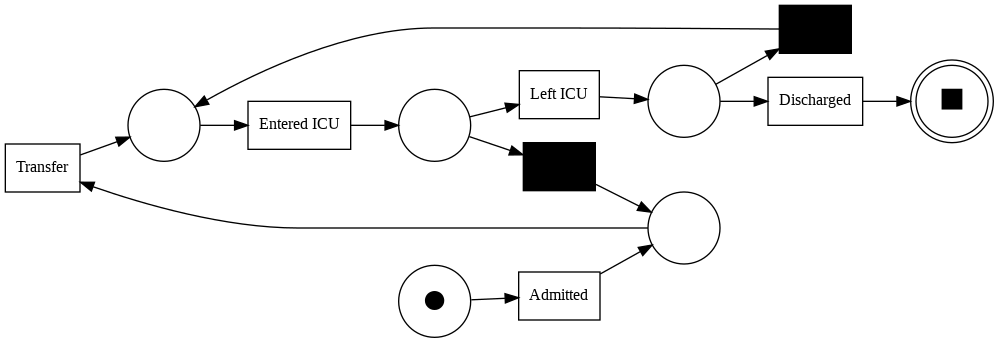

In [55]:
# format train event log as pm4py event log
train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
# petri net from heuristics miner
heuristic_net, heuristic_im, heuristic_fm = pm.discover_petri_net_heuristics(train_log, dependency_threshold=0.985)
pm.view_petri_net(heuristic_net, heuristic_im, heuristic_fm)

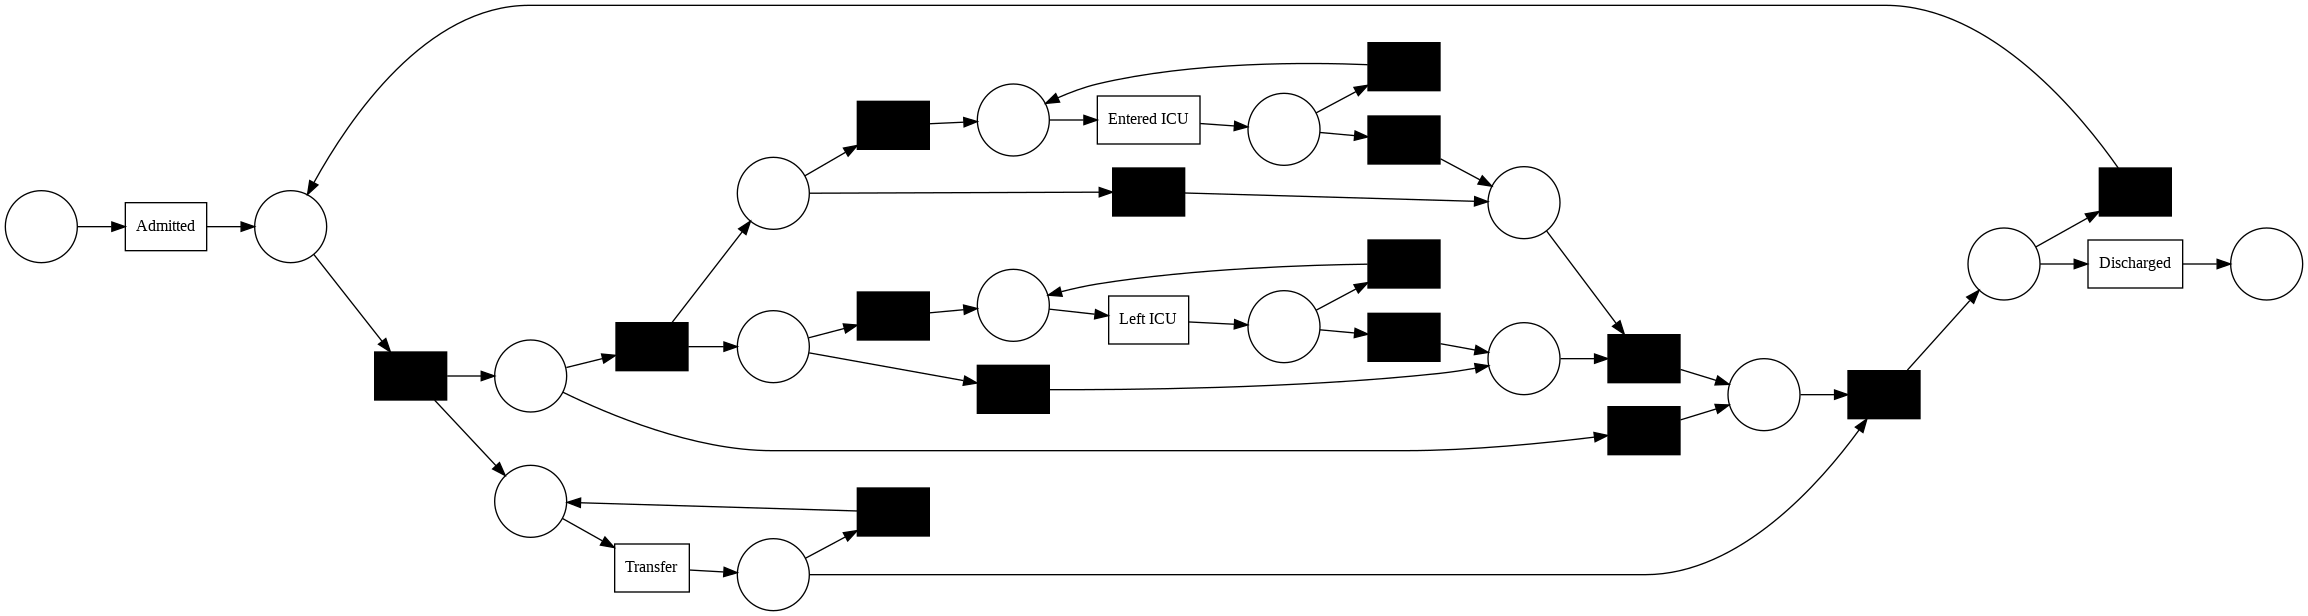

In [56]:
inductive_net, inductive_im, inductive_fm = pm.discover_petri_net_inductive(train_log)
pm.view_petri_net(petri_net=inductive_net)

###4.2

In [57]:
def replay_trace(el):
  # log = pm.format_dataframe(el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
  replay_result = pm.fitness_token_based_replay(el, heuristic_net, heuristic_im, heuristic_fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  return replay_result['average_trace_fitness']

In [58]:
def generate_traces(sequence, missing, trace):
    timestamps = sequence['timestamp'].tolist()
    if missing.iat[0,1] == 'Admitted':
      return pd.concat([missing,sequence], ignore_index=True)
    if missing.iat[0,1] == 'Discharged':
      return pd.concat([sequence,missing], ignore_index=True)
     
    trace_length = len(timestamps) -1
    best_fitness = 0
    best_trace = None
    for i in range(1,trace_length):
      df = pd.concat([sequence.head(i), missing, sequence.tail(trace_length-i)], ignore_index=True)
      inputed_df = deepcopy(df)
      previous_timestamp = inputed_df.iat[i-1,2]
      next_timestamp = inputed_df.iat[i+1,2]
      inputed_timestamp = previous_timestamp + (next_timestamp-previous_timestamp)/2 
      inputed_df.iat[i,2] = inputed_timestamp
      fitness = replay_trace(inputed_df)
      fitness = 1
      if fitness > best_fitness:
        best_fitness = fitness
        best_trace = df

    return best_trace


In [59]:
def predict_sequences(el):
  df = pd.DataFrame(columns=['trace','activity','timestamp'])
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    trace_df = el[:][test_el.trace == t]
    sequence = trace_df.loc[trace_df['timestamp'].notna()]
    missing = trace_df.loc[trace_df['timestamp'].isna()]
 
    predicted_trace = generate_traces(sequence, missing, t)
    df = pd.concat([df,predicted_trace], ignore_index=True)

  return df

test_sequences = predict_sequences(test_x)


In [71]:
def label_test(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    df = el[:][el.trace == t]
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i]
      # if pd.isnull(timestamp):
      timestamp =  (df['timestamp'][i] - start_time).total_seconds() / 10_000_000_000

      timestamps.append(timestamp)
    
    length = len(timestamps)
    order = 0
    for i in range(length):
      if pd.isnull(timestamps[i]):
        order = i
        break

    label = activities[order]
    time_label = timestamps[order]
    prefix = activities[:order]
    prefix_times = timestamps[:order]

    suffix, suffix_times = [], []

    if i != length - 1:
      suffix = activities[i+1:]
      suffix_times = timestamps[i+1:]

    padding = []

    while len(prefix) + len(padding) < PREFIX_LENGTH:
      padding.append('0')
    
    prefix = padding + prefix
      
    padding = []
    
    while len(prefix_times) + len(padding) < PREFIX_LENGTH:
      padding.append('0')
    
    prefix_times =  padding + prefix_times

    while len(suffix) < PREFIX_LENGTH:
      suffix.append('0')

    while len(suffix_times) < PREFIX_LENGTH:
      suffix_times.append('0')

    f = '%Y-%d-%m %H:%M:%S'
    for i in range(PREFIX_LENGTH):
      try:
        prefix_times[i] = pd.to_datetime(prefix_times[i], format=f).value
        # suffix_times[i] = pd.to_datetime(suffix_times[i], format=f).value
      except ValueError:
        continue

    for i in range(PREFIX_LENGTH):
      try:
        # prefix_times[i] = pd.to_datetime(prefix_times[i], format=f).value
        suffix_times[i] = pd.to_datetime(suffix_times[i], format=f).value
      except ValueError:
        continue

    prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
    suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
    prefix_times_arr.append(np.array(prefix_times[:PREFIX_LENGTH], dtype=int))
    suffix_times_arr.append(np.array(suffix_times[:PREFIX_LENGTH], dtype=int))
    label_arr.append(label)
    label_times_arr.append(time_label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix times' : prefix_times_arr,
                       'suffix times' : suffix_times_arr,
                       'activity label' : label_arr,
                       'timestamp label': label_times_arr})


In [72]:
label_test(test_sequences)

,prefix,suffix,prefix time delta,suffix time delta,activity label,timestamp label
0,"[0, 0, 0, 0, 1]","[4, 5, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",2,NaN
1,"[0, 0, 0, 0, 1]","[4, 5, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",2,NaN
2,"[0, 0, 0, 0, 1]","[4, 5, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",2,NaN
3,"[0, 0, 0, 0, 1]","[3, 2, 4, 2, 3]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",2,NaN
4,"[1, 2, 3, 4, 3]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",5,NaN
5,"[0, 0, 0, 0, 1]","[4, 5, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",3,NaN
6,"[0, 0, 0, 0, 1]","[2, 3, 2, 4, 4]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",3,NaN
7,"[0, 1, 2, 3, 4]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",5,NaN
8,"[0, 0, 0, 0, 0]","[2, 3, 4, 5, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",1,NaN
9,"[0, 0, 0, 0, 1]","[4, 5, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",2,NaN


## Section 5: Predicting timestamp using LSTM 

In [38]:
from keras.layers import Dropout, Input, Bidirectional, LSTM, average, Dense
from keras import Model

prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_times_input')
suffix_times_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_times_input')

lstm_layer = LSTM(96)

prefix_events_lstm = Bidirectional(lstm_layer, name='prefix_events_lstm')(prefix_events_input)
suffix_events_lstm = Bidirectional(lstm_layer, name='suffix_events_lstm')(suffix_events_input)
prefix_times_lstm = Bidirectional(lstm_layer, name='prefix_times_lstm')(prefix_times_input)
suffix_times_lstm = Bidirectional(lstm_layer, name='suffix_times_lstm')(suffix_times_input)


dropout_prefix_events = Dropout(0.2)(prefix_events_lstm)
dropout_suffix_events = Dropout(0.2)(suffix_events_lstm)
dropout_prefix_times = Dropout(0.2)(prefix_times_lstm)
dropout_suffix_times = Dropout(0.2)(suffix_times_lstm)


merged = average([dropout_prefix_events, dropout_suffix_events, dropout_prefix_times, dropout_suffix_times], name='merged')

output = Dense(n_activities, name='output')(merged)

best_model = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_times_input, suffix_times_input],
    outputs=output)
best_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
best_model.summary()
best_model.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_times_input (InputLayer  [(None, 5, 1)]      0           []                               
 )                                                                                          